In [665]:
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from pydot import graph_from_dot_data
import io
import math
import random

eps = 1e-5  # a small number
random.seed(0)
np.random.seed(0)

In [666]:
#Q4.1 Implement Decision Trees
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, pred=None, features=[]):
        self.features = features
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.pred = pred
    def __repr__(self):

        if self.feature != None: 
            return "[%s <= %s:  %s | %s]" % (self.features[self.feature],
                                                self.threshold, self.left.__repr__(),
                                                self.right.__repr__())
        return self.pred
class DecisionTree:
    def __init__(self, min_n_samples=2, max_depth=3, n_features=None, features=[]):
        self.min_n_samples=min_n_samples
        self.max_depth=max_depth
        self.n_features=n_features
        self.features = features
        self.root=None

    def entropy(self, y):
        counter = Counter(y)
        entro = 0
        for key in counter:
            p_c = counter[key] / len(y)
            entro += (-1 * p_c * math.log2(p_c))
        return entro
    
    def information_gain(self, y, X_col, threshold):
        parent = self.entropy(y)
        left_idxs, right_idxs = self.split(X_col, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        child =  (len(left_idxs) * self.entropy(y[left_idxs]) + len(right_idxs) * self.entropy(y[right_idxs])) / len(y)
        return parent  - child

    def predict(self, X):
        def helper(x, node):
            if node.pred != None:
                return node.pred
            if x[node.feature] <= node.threshold:
                return helper(x, node.left)
            return helper(x, node.right)
        return np.array([helper(x, self.root) for x in X])
    
    def fit(self, X, y):
        if self.n_features == None:
            self.n_features = X.shape[1]
        else:
            self.n_features = min(X.shape[1],self.n_features)
        self.root = self.tree(X, y, 0)

    def tree(self, X, y, depth):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

    
        if (depth >= self.max_depth or n_samples < self.min_n_samples or n_labels == 1):
            counter = Counter(y)
            class_label = counter.most_common(1)[0][0]
            if isinstance(class_label, bytes):
                leaf_value = int(float(class_label.decode()))
            else: 
                leaf_value = int(class_label)
        
            return Node(pred=leaf_value, features=self.features)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)


        best_feature, best_thresh = self.best_split(X, y, feat_idxs)
        

        left_idxs, right_idxs = self.split(X[:, best_feature], best_thresh)
        left, right = None, None
        if len(left_idxs) >= 1 and len(right_idxs) >= 1: 
            left = self.tree(X[left_idxs, :], y[left_idxs], depth+1)
            right = self.tree(X[right_idxs, :], y[right_idxs], depth+1)
            return Node(best_feature, best_thresh, left, right, features=self.features)
        else: 
            counter = Counter(y)
            class_label = counter.most_common(1)[0][0]
            if isinstance(class_label, bytes):
                leaf_value = int(float(class_label.decode()))
            else: 
                leaf_value = int(class_label)
            return Node(pred=leaf_value, features=self.features)


    def best_split(self, X, y, feat_idxs):
        best_gain = -math.inf
        best_feature, best_thresh = None, None
        for feat in feat_idxs:
            X_col = X[:, feat]
            thresholds = np.unique(X_col)

            for thresh in thresholds:
                gain = self.information_gain(y, X_col, thresh)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feat
                    best_thresh = thresh

        return best_feature, best_thresh

    def split(self, X_column, split_thresh):
        left_idxs = np.where(X_column <= split_thresh)[0]
        right_idxs = np.where(X_column > split_thresh)[0]
        return left_idxs, right_idxs
    
    def __repr__(self):
        return self.root.__repr__()



In [667]:
# Q4.2 Implement a Random Forest
class RandomForest:
    def __init__(self, n=200, n_features=2):
      
        self.n = n
        self.decision_trees = [
            DecisionTree(n_features=n_features)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            indx = np.random.randint(0, X.shape[0], X.shape[0])
            newX, newy = X[indx, :], y[indx]
            self.decision_trees[i].fit(newX, newy)
        return self

    def predict(self, X):
        yhat = [self.decision_trees[i].predict(X) for i in range(self.n)]
        return np.array(np.round(np.mean(yhat, axis=0)),dtype=np.bool)


In [668]:

def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    feature = data[0, :]
    data = data[1:, :]
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
    
    onehot_encoding = np.array(onehot_encoding).T

    mask = np.ones(data.shape[1], dtype=bool)

    mask[onehot_cols] = False
    data = data[:, mask]
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])
    feature = feature[mask]

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for col in range(len(data[0])):
            counter = Counter(data[:, col])
            mode = math.inf
            for key in counter.most_common():
                if key[0] != -2:
                    mode = key[0]
                    break 
            
            data[data[:, col] == -1, col] = mode
    onehot_features = np.array(onehot_features)
 
    return data, np.concatenate((feature, onehot_features))

In [669]:
# Q 4.4 Performance Evaluation
# titanic decision tree 
path_train = 'datasets/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)
validate_data = data[:100] 
train_data = data[100:]

path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)


y_train = train_data[1:, 0]  # label = survive
y_validate = validate_data[1:, 0]
class_names = ["Died", "Survived"]
# pclass,sex, age, sibsp, parch, ticket, fare, cabin, embarked
# 0        1     2    3    4      5       6      7      8    9    
X_train, features = preprocess(train_data[:, 1:], onehot_cols=[1, 5, 7, 8])
X_validate, features = preprocess(validate_data[:, 1:], onehot_cols=[1, 5, 7, 8])
X_test, features_test = preprocess(test_data, onehot_cols=[1, 5, 7, 8])




DT = DecisionTree(max_depth=10, features=features)
# train
DT.fit(X_train, y_train)
y_train = [int(float(e.decode())) for e in y_train]
train_accuracy = sum(np.ones(len(y_train), dtype=int)[DT.predict(X_train) == y_train]) / len(y_train)
train_accuracy = round(train_accuracy * 100, 2)

y_validate = [int(float(e.decode())) for e in y_validate]
validate_accuracy = sum(np.ones(len(y_validate), dtype=int)[DT.predict(X_validate) == y_validate]) / len(y_validate)
validate_accuracy = round(validate_accuracy * 100, 2)

print(f"titanic deicsion tree training accuracy: {train_accuracy} %")
print(f"titanic deicsion tree validatoin accuracy: {validate_accuracy} %")


/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/3371476757.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/3371476757.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


titanic deicsion tree training accuracy: 89.99 %
titanic deicsion tree validatoin accuracy: 85.86 %


In [670]:
# titanic random forest 
path_train = 'datasets/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)
validate_data = data[:100] 
train_data = data[100:]

path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)


y_train = train_data[1:, 0]  # label = survive
y_validate = validate_data[1:, 0]
class_names = ["Died", "Survived"]
# pclass,sex, age, sibsp, parch, ticket, fare, cabin, embarked
# 0        1     2    3    4      5       6      7      8    9    
X_train, features = preprocess(train_data[:, 1:], onehot_cols=[1, 5, 7, 8])
X_validate, features = preprocess(validate_data[:, 1:], onehot_cols=[1, 5, 7, 8])
X_test, features_test = preprocess(test_data, onehot_cols=[1, 5, 7, 8])



randomForest = RandomForest(n=200, n_features=8)
# train
randomForest.fit(X_train, y_train)
y_train = [int(float(e.decode())) for e in y_train]
train_accuracy = sum(np.ones(len(y_train), dtype=int)[randomForest.predict(X_train) == y_train]) / len(y_train)
train_accuracy = round(train_accuracy * 100, 2)

y_validate = [int(float(e.decode())) for e in y_validate]
validate_accuracy = sum(np.ones(len(y_validate), dtype=int)[randomForest.predict(X_validate) == y_validate]) / len(y_validate)
validate_accuracy = round(validate_accuracy * 100, 2)
print(f"titanic radom forest training accuracy: {train_accuracy} %")
print(f"titanic random forest validatoin accuracy: {validate_accuracy} %")

/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/2597222765.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/2597222765.py:8: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


titanic radom forest training accuracy: 80.09 %
titanic random forest validatoin accuracy: 82.83 %


/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/1936655912.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(np.round(np.mean(yhat, axis=0)),dtype=np.bool)


In [671]:
# spam kaggle use decision tree
import os
import csv


data = [{"Id": i+1, "Category": label} for i, label in enumerate(DT.predict(X_test))]
csv_file_path = os.path.join(os.getcwd(), "titanic_kaggle.csv")

fields = ["Id", "Category"]

# Writing to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)

    # Write the header
    writer.writeheader()

    # Write the data
    writer.writerows(data)


In [672]:
# Q4.6 train a shallow tree in taitanic and then visualize it 
path_train = 'datasets/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)
validate_data = data[:100] 
train_data = data[100:]

path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)


y_train = train_data[1:, 0]  # label = survive
y_validate = validate_data[1:, 0]
class_names = ["Died", "Survived"]
# pclass,sex, age, sibsp, parch, ticket, fare, cabin, embarked
# 0        1     2    3    4      5       6      7      8    9    
X_train, features = preprocess(train_data[:, 1:], onehot_cols=[1, 5, 7, 8])
DT = DecisionTree(max_depth=3, features=features)
DT.fit(X_train, y_train)
print(DT)


/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/3621720374.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/3621720374.py:8: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


[b'female' <= 0.0:  [b'1.0' <= 1.0:  [b'21.0' <= 54.0:  0 | 0] | [b'21.0' <= 32.0:  0 | 0]] | [b'1.0' <= 2.0:  [b'61.3792' <= 31.6792:  1 | 1] | [b'61.3792' <= 23.25:  1 | 0]]]


In [673]:
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription",
    "creative", "height", "featured", "differ", "width", "other",
    "energy", "business", "message", "volumes", "revision", "path",
    "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
    "square_bracket", "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']


DT = DecisionTree(min_n_samples=15, max_depth=15)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_validate = X[train_size:]
y = np.squeeze(data['training_labels'])
y_train = y[:train_size]
y_validate = y[train_size:]
X_test = data['test_data']
class_names = ["Ham", "Spam"]
DT.fit(X_train, y_train)
train_accuracy = sum(np.ones(len(y_train), dtype=int)[DT.predict(X_train) == y_train]) / len(y_train)
train_accuracy = round(train_accuracy * 100, 2)


validate_accuracy = sum(np.ones(len(y_validate), dtype=int)[DT.predict(X_validate) == y_validate]) / len(y_validate)
validate_accuracy = round(validate_accuracy * 100, 2)

print(f"spam deicsion tree training accuracy: {train_accuracy} %")
print(f"spam deicsion tree validatoin accuracy: {validate_accuracy} %")


spam deicsion tree training accuracy: 86.36 %
spam deicsion tree validatoin accuracy: 83.21 %


In [674]:
randomForest = RandomForest(n=200, n_features=25)

randomForest.fit(X_train, y_train)
train_accuracy = sum(np.ones(len(y_train), dtype=int)[randomForest.predict(X_train) == y_train]) / len(y_train)
train_accuracy = round(train_accuracy * 100, 2)


validate_accuracy = sum(np.ones(len(y_validate), dtype=int)[randomForest.predict(X_validate) == y_validate]) / len(y_validate)
validate_accuracy = round(validate_accuracy * 100, 2)

print(f"spam deicsion tree training accuracy: {train_accuracy} %")
print(f"spam deicsion tree validatoin accuracy: {validate_accuracy} %")


/var/folders/xq/tfkf_chd7ln1y99db9qmfx540000gn/T/ipykernel_72640/1936655912.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(np.round(np.mean(yhat, axis=0)),dtype=np.bool)


spam deicsion tree training accuracy: 80.44 %
spam deicsion tree validatoin accuracy: 79.31 %


In [675]:
import os
import csv


data = [{"Id": i+1, "Category": label} for i, label in enumerate(DT.predict(X_test))]
csv_file_path = os.path.join(os.getcwd(), "spam_kaggle.csv")

fields = ["Id", "Category"]

# Writing to CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)

    # Write the header
    writer.writeheader()

    # Write the data
    writer.writerows(data)

In [676]:
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription",
    "creative", "height", "featured", "differ", "width", "other",
    "energy", "business", "message", "volumes", "revision", "path",
    "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
    "square_bracket", "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']


DT = DecisionTree(min_n_samples=15, max_depth=3, features=features)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_validate = X[train_size:]
y = np.squeeze(data['training_labels'])
y_train = y[:train_size]
y_validate = y[train_size:]
X_test = data['test_data']
class_names = ["Ham", "Spam"]
DT.fit(X_train, y_train)
print(DT)

[exclamation <= 0.0:  [parenthesis <= 0.0:  [creative <= 0.0:  0 | 1] | [money <= 0.0:  0 | 1]] | [parenthesis <= 0.0:  [money <= 0.0:  1 | 1] | [dollar <= 1.0:  0 | 1]]]


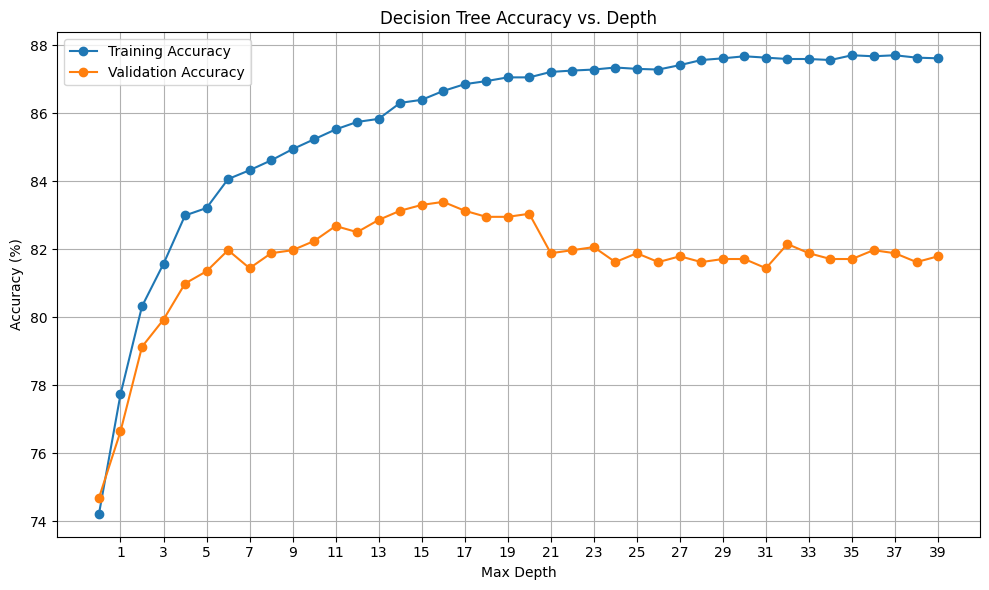

In [677]:
import matplotlib.pyplot as plt

train_accuracy_depth = []
validate_accuracy_depth = []
for i in range(1, 41):
    DT = DecisionTree(min_n_samples=15, max_depth=i)
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    X_validate = X[train_size:]
    y = np.squeeze(data['training_labels'])
    y_train = y[:train_size]
    y_validate = y[train_size:]
    X_test = data['test_data']
    class_names = ["Ham", "Spam"]
    DT.fit(X_train, y_train)
    train_accuracy = sum(np.ones(len(y_train), dtype=int)[DT.predict(X_train) == y_train]) / len(y_train)
    train_accuracy = round(train_accuracy * 100, 2)


    validate_accuracy = sum(np.ones(len(y_validate), dtype=int)[DT.predict(X_validate) == y_validate]) / len(y_validate)
    validate_accuracy = round(validate_accuracy * 100, 2)
    train_accuracy_depth.append(train_accuracy)
    validate_accuracy_depth.append(validate_accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(0, 40), train_accuracy_depth, label='Training Accuracy', marker='o')
plt.plot(range(0, 40), validate_accuracy_depth, label='Validation Accuracy', marker='o')

plt.title('Decision Tree Accuracy vs. Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, 41, 2))
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()